In [1]:
import sys
sys.path.append("../../")

from shared.sae_actions import load_pretrained_sae, sae_featurize_data 
from shared.models import MiniPileDataset
from shared.features import Feature, FeatureSample

%load_ext autoreload
%autoreload 2

/home/ubuntu/joe/predictive-saes/encoder_sae/venv/lib/python3.10/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_mutation' has been removed
  warnings.warn(message, UserWarning)


In [2]:
import glob
import json
import os

def load_features(feature_dir):
    """Load features from JSON files and convert to Feature objects"""
    # Get all JSON files from the features directory
    feature_files = glob.glob(os.path.join(feature_dir, "*.json"))

    # Load all feature JSONs into Feature objects
    features = []
    for file in feature_files:
        with open(file) as f:
            feature_dict = json.load(f)
            
            # Convert samples to FeatureSample objects
            high_act_samples = [
                FeatureSample(text=s["text"], act=s["act"]) 
                for s in feature_dict["high_act_samples"]
            ]
            low_act_samples = [
                FeatureSample(text=s["text"], act=s["act"])
                for s in feature_dict["low_act_samples"] 
            ]
            
            feature = Feature(
                index=feature_dict["index"],
                label=feature_dict["label"],
                attributes=feature_dict["attributes"],
                reasoning=feature_dict["reasoning"],
                density=feature_dict["density"],
                confidence=feature_dict["confidence"],
                high_act_samples=high_act_samples,
                low_act_samples=low_act_samples
            )
            features.append(feature)

    # Sort features by index to maintain order
    features.sort(key=lambda x: x.index)

    # Extract labels and ids for easy reference
    autointerp_feature_labels = [f.label for f in features]
    autointerp_feature_ids = [f.index for f in features]

    return features, autointerp_feature_labels, autointerp_feature_ids

# Load features
feature_dir = "../feature_extraction/features/spam_messages_roberta_tied_weights"
features, autointerp_feature_labels, autointerp_feature_ids = load_features(feature_dir)


In [3]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

def prepare_dataset(sentences_file, embeddings_file, sae, autointerp_feature_ids=None, feature_registry_file="feature_registry.npy", label_column='label', text_key="text", split_sentences=True):
    # Load dataset
    df = pd.read_csv(sentences_file)
    
    # Create MiniPileDataset
    mini_pile_dataset = MiniPileDataset(sentences_file, embeddings_file, key=text_key)
    
    # Featurize data
    try:
        X = np.memmap(
            feature_registry_file,
            dtype="float32",
            mode="r",
            shape=(sae.encoder.weight.shape[0], len(mini_pile_dataset.sentences)),
        )
    except FileNotFoundError:
        X = sae_featurize_data(mini_pile_dataset, sae, output_file=feature_registry_file)
    
    X = X.T
    
    # Apply num_features if specified
    if autointerp_feature_ids is not None:
        X = X[:, autointerp_feature_ids]
    
    y = np.where(df[label_column] == 'ham', 0, 1)
    
    if split_sentences:
        X_split = []
        y_split = []
        for i, text in enumerate(df[text_key]):
            sentences = sent_tokenize(text)
            X_split.extend([X[i]] * len(sentences))
            y_split.extend([y[i]] * len(sentences))
        X = np.array(X_split)
        y = np.array(y_split)
    
    return X, y

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# Load SAE
sae = load_pretrained_sae("../training_sae/saes/spam_messages_roberta_tied_weights_20241206_111202")

In [5]:
sentences_file = "../data_preparation/data/spam_messages_test.csv"
embeddings_file = "../data_preparation/embedding_chunks/embedded_chunks/spam_test_item_20241206_220900/embeddings.npy"
X_test, y_test = prepare_dataset(sentences_file, embeddings_file, sae, autointerp_feature_ids=autointerp_feature_ids, feature_registry_file="feature_registry_test_all.npy", split_sentences=False)

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_feature_distribution(X_test, y_test, idx, bins=100):
    # Separate the feature values by class
    ham_values = X_test[y_test == 0, idx]
    spam_values = X_test[y_test == 1, idx]
    
    # Create histogram with specified x-axis range
    plt.figure(figsize=(10, 6))
    plt.hist(ham_values, bins=bins, alpha=0.5, label='Ham', density=False, range=(0.000, 5))
    plt.hist(spam_values, bins=bins, alpha=0.5, label='Spam', density=False, range=(0.000, 5))
    
    plt.xlabel(f'Activation Value')
    plt.ylabel('Count')
    plt.title(f'Feature: {autointerp_feature_labels[idx]}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [22]:
feature

2104

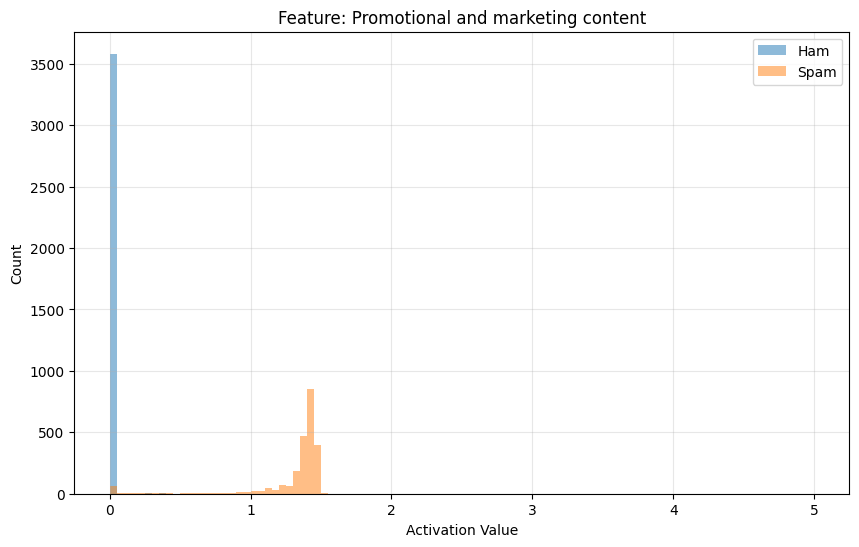

In [32]:
plot_feature_distribution(X_test, y_test, 0)